In [1]:
import sys
sys.path.append("..")

import numpy as np
from tqdm.notebook import tqdm
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import seaborn as sns
from copy import deepcopy

from environments.frozen_lake.utils import FLActions, fl_observation_to_premises, fl_premises_to_args, arg_actions_naive, arg_actions_advanced2, arg_actions_advanced3, arg_actions_advanced4
from environments.co_aa.co_aa import COAAenv
from agents.co_aa_agent import COAAAgent
from agents.frozen_lake_agent import FLAAAgent, FrozenLakeAgent, FLRandomAgent, FLRandomAwareAgent, FLHandcraftedAgent

from argumentation.classes import ArgumentationFramework, ValuebasedArgumentationFramework
from argumentation.utils import construct_all_attacks

from utils import run_episode, new_fl_env


In [2]:
arg_actions_naive = arg_actions_naive
args_naive = list(arg_actions_naive.keys())
atts_naive = construct_all_attacks(arg_actions_naive)
af_naive = ArgumentationFramework(args_naive, atts_naive)

arg_actions_advanced = arg_actions_advanced3
args_advanced = list(arg_actions_advanced3.keys())
atts_advanced = construct_all_attacks(arg_actions_advanced)
af_advanced = ArgumentationFramework(args_advanced, atts_advanced)

### B: OOD generalisation: Training on a Game Distribution

In [3]:
n = 8
p = 0.8

rewards_b = []
previous_policy = []
policy_count = 0
eval_b = []

vaf_advanced = ValuebasedArgumentationFramework(args_advanced, atts_advanced, [])
aa_agent_advanced = FLAAAgent(vaf_advanced, arg_actions_advanced, fl_observation_to_premises, fl_premises_to_args, n)

for run in range(1, 1+1):
    epsilon = 0.1
    gamma = 0.99
    alpha = 5e-3
    agent_co = COAAAgent(alpha, gamma, epsilon, af_advanced.args)

    t_episodes = tqdm(range(1, int(1e5)+1), desc='run: {}'.format(run))
    for epi in  t_episodes:
        co_env = COAAenv(args_advanced, arg_actions_advanced, af_advanced, new_fl_env(n, p), fl_observation_to_premises, fl_premises_to_args, aa_agent_advanced)

        agent_co.alpha = np.max([agent_co.alpha*(1-1e-4), 1e-4])
        agent_co.epsilon = np.max([agent_co.epsilon*(1-1e-4), 0.01])
        
        start_state = co_env.reset()
        end_state, total_reward, animation_data = run_episode(co_env, agent_co, start_state, is_learning=True, is_animating=False, is_rendering=False)
        if agent_co.order == previous_policy:
            policy_count += 1
        else:
            policy_count = 0
        previous_policy = agent_co.order
        rewards_b.append([run, epi, total_reward, policy_count, 'symbolic-advanced'])

        if epi % 100 == 0:
            rew = 0
            N = 10
            for i in range(1, N+1):
                
                vaf = ValuebasedArgumentationFramework(args_advanced, atts_advanced, agent_co.order)
                aa_agent = FLAAAgent(vaf, arg_actions_advanced, fl_observation_to_premises, fl_premises_to_args, n)
                co_env = COAAenv(args_advanced, arg_actions_advanced, af_advanced, new_fl_env(n, p), fl_observation_to_premises, fl_premises_to_args, aa_agent)
                rew += co_env._get_game_reward(False) == 1
            eval_b.append((epi, (rew/N)*100))

            t_episodes.set_postfix({'avg': np.average([rew[2] for rew in rewards_b[-100:]]), 'eval': str(eval_b[-1][1])+'%'})

rewards_b = pd.DataFrame(rewards_b, columns=('run', 'episode', 'reward', 'policy_count', 'agent'))
timestamp_b = datetime.now().strftime("%d%m%Y-%H%M%S")
filename_b = "../../data/exp-B-{}.csv".format(timestamp_b)
rewards_b.to_csv(filename_b)

filename_b_m = "../../models/exp-B-{}.npy".format(timestamp_b)
np.save(filename_b_m, agent_co.w)
# agent_co.w = np.load(filename_b_m)

eval_b = pd.DataFrame(eval_b, columns=('episode', 'acc'))
filename_b_e = "../../data/exp-B-eval-{}.csv".format(timestamp_b)
eval_b.to_csv(filename_b_e)

run: 1:   0%|          | 0/100000 [00:00<?, ?it/s]

c:\Users\omcan\miniconda3\envs\py39\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\omcan\miniconda3\envs\py39\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


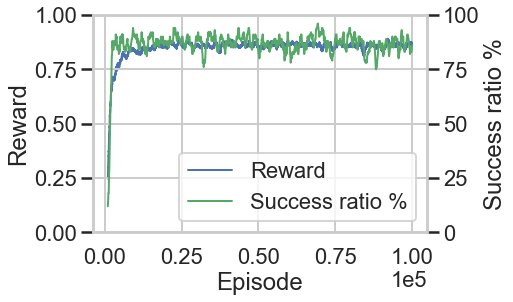

In [4]:
sns.set(rc = {'figure.figsize':(15,8)}, style='whitegrid')
sns.set_context("poster", rc={"lines.linewidth": 2}, font_scale=1)

eval_b = pd.DataFrame(eval_b, columns=('episode', 'acc'))
eval_b['acc_avg'] = eval_b['acc'].transform(lambda x: x.rolling(10).mean())

rewards_b = pd.DataFrame(rewards_b, columns=('run', 'episode', 'reward', 'policy_count', 'agent'))
rewards_b['reward_avg'] = rewards_b.groupby(['run', 'agent'])['reward'].transform(lambda x: x.rolling(1000).mean())
  
rewards_b_plot = sns.lineplot(x='episode', y='reward_avg', data=rewards_b, ci='sd', color="b")
rewards_b_plot.set(ylim=(0, 1))
rewards_b_plot.set(ylabel="Reward")

right_y = rewards_b_plot.axes.twinx()
sns.lineplot(x='episode', y='acc_avg', data=eval_b, color="g", ax=right_y, ci='sd')
plt.legend(loc='lower right', handles=[Line2D([], [], marker='_', color="b", label='Reward'), Line2D([], [], marker='_', color="g", label='Success ratio %')], facecolor='white')
right_y.set(ylim=(lim*100 for lim in rewards_b_plot.get_ylim()))
right_y.set(ylabel="Success ratio %")

rewards_b_plot.set(xlabel="Episode")
# rewards_b_plot.set(xlim=(0, 1e6))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


In [5]:
rewards_c = []
previous_policy = []
policy_count = 0
eval_c = []
n = 8
p = 0.8
for run in range(1, 1+1):
    epsilon = 0.05
    gamma = 0.99
    alpha = 1e-1
    agent = FrozenLakeAgent(n, alpha, gamma, epsilon, True)

    t_episodes = tqdm(range(1, int(1e5)+1), desc='run: {}'.format(run))
    for epi in  t_episodes:

        env = new_fl_env(n,p)

        agent.alpha = np.max([agent.alpha*(1-1e-4), 1e-2])
        agent.epsilon = np.max([agent.epsilon*(1-1e-4), 0.01])
        
        start_state = env.reset()

        end_state, total_reward, animation_data = run_episode(env, agent, start_state, is_learning=True, is_animating=False, is_rendering=False)

        rewards_c.append([run, epi, total_reward, policy_count, 'non-symbolic'])

        if epi % 100 == 0:
            rew = 0
            N = 10
            for i in range(1, N+1):
                env = new_fl_env(n,p)
                start_state = env.reset()
                _, reward, _ = run_episode(env, agent, start_state, is_learning=False, is_animating=False, is_rendering=False)
                rew += reward == 1
            eval_c.append((epi, (rew/N)*100))

            t_episodes.set_postfix({'avg': np.average([rew[2] for rew in rewards_c[-100:]]), 'eval': str(eval_c[-1][1])+'%'})

rewards_c = pd.DataFrame(rewards_c, columns=('run', 'episode', 'reward', 'policy_count', 'agent'))
timestamp_c = datetime.now().strftime("%d%m%Y-%H%M%S")
filename_c = "../../data/exp-C-{}.csv".format(timestamp_c)
rewards_c.to_csv(filename_c)

filename_c_m = "../../models/exp-C-{}.npy".format(timestamp_c)
np.save(filename_c_m, agent_co.w)
# agent_co.w = np.load(filename_c_m)

eval_c = pd.DataFrame(eval_c, columns=('episode', 'acc'))
filename_c_e = "../../data/exp-C-eval-{}.csv".format(timestamp_c)
eval_c.to_csv(filename_c_e)

run: 1:   0%|          | 0/100000 [00:00<?, ?it/s]

c:\Users\omcan\miniconda3\envs\py39\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\omcan\miniconda3\envs\py39\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


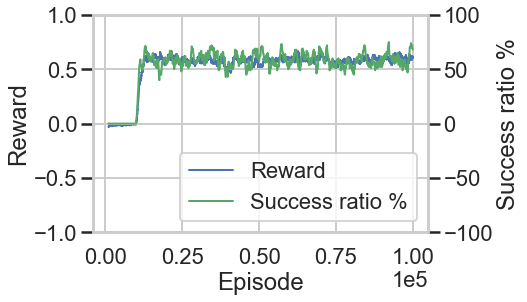

In [6]:
# filename_c_e = '../../data/exp-C-eval-24092022-022211.csv'
# eval_c = pd.read_csv(filename_c_e)

eval_c = pd.DataFrame(eval_c, columns=('episode', 'acc'))
eval_c['acc_avg'] = eval_c['acc'].transform(lambda x: x.rolling(10).mean())

# filename_c = '../../data/exp-C-24092022-022211.csv'
# rewards_c = pd.read_csv(filename_c)

rewards_c = pd.DataFrame(rewards_c, columns=('run', 'episode', 'reward', 'policy_count', 'agent'))
rewards_c['reward_avg'] = rewards_c.groupby(['run', 'agent'])['reward'].transform(lambda x: x.rolling(1000).mean())
  
rewards_c_plot = sns.lineplot(x='episode', y='reward_avg', data=rewards_c, ci='sd', color="b")
rewards_c_plot.set(ylim=(-1, 1))
rewards_c_plot.set(ylabel="Reward")

right_y = rewards_c_plot.axes.twinx()
sns.lineplot(x='episode', y='acc_avg', data=eval_c, color="g", ax=right_y, ci='sd')
plt.legend(loc='lower right', handles=[Line2D([], [], marker='_', color="b", label='Reward'), Line2D([], [], marker='_', color="g", label='Success ratio %')], facecolor='white')
right_y.set(ylim=(lim*100 for lim in rewards_c_plot.get_ylim()))
right_y.set(ylabel="Success ratio %")

rewards_c_plot.set(xlabel="Episode")
# rewards_c_plot.set(xlim=(0, 1e6))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
sns.set(rc = {'figure.figsize':(15,8)}, style='whitegrid')
sns.set_context("poster", rc={"lines.linewidth": 2}, font_scale=1)


#### B.2: Generalisation

In [7]:
n_runs = 1000

handcrafted_agent = FLHandcraftedAgent()

rewards_d = []
# for run in range(1,n_runs+1):
t_runs = tqdm(range(1, n_runs+1))
for run in t_runs:
    for size in [8, 16]:
        for p in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
            # for epi in tqdm(range(1, 1+1), desc='run: {}, size:{}, p={}'.format(run, size, p)):
            for epi in range(1,2):
                fl_env = new_fl_env(size, p=p)
                
                start_state = fl_env.reset()
                end_state, total_reward, animation_data = run_episode(fl_env, handcrafted_agent, start_state, is_learning=False, is_animating=False, is_rendering=False)
                rewards_d.append((run, size, p, total_reward, 'HA'))
                
                vaf_aux = ValuebasedArgumentationFramework(args_advanced, atts_advanced, agent_co.order)
                aa_agent_aux = FLAAAgent(vaf_aux, arg_actions_advanced, fl_observation_to_premises, fl_premises_to_args, size)
                co_env = COAAenv(args_advanced, arg_actions_advanced, af_advanced, fl_env, fl_observation_to_premises, fl_premises_to_args, aa_agent_aux)
                total_reward = co_env._get_game_reward(False)
                rewards_d.append((run, size, p, total_reward, 'advanced SA'))

                start_state = fl_env.reset()
                aux_agent = FrozenLakeAgent(size, agent.alpha, agent.gamma, agent.epsilon, True)
                aux_agent.w[:len(agent.w)] = agent.w
                _, total_reward, _ = run_episode(fl_env, aux_agent, start_state, is_learning=False, is_animating=False, is_rendering=False)
                rewards_d.append((run, size, p, total_reward, 'NSA'))
                

# rewards_d = pd.DataFrame(rewards_d, columns=('run', 'size', 'p', 'reward', 'agent'))
# timestamp_d = datetime.now().strftime("%d%m%Y-%H%M%S")
# # timestamp_d = timestamp_a
# filename_d = "../../data/exp3-B-{}.csv".format(timestamp_d)
# rewards_d.to_csv(filename_d)

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\omcan\AppData\Local\Temp\ipykernel_15392\4179009882.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


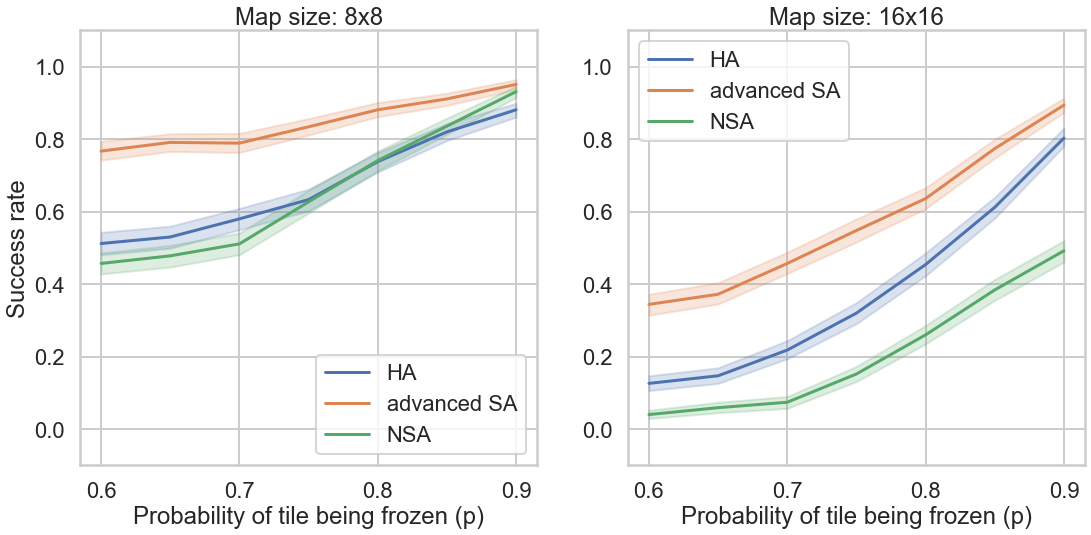

In [8]:

sns.set(rc = {'figure.figsize':(18,8)}, style='whitegrid')
sns.set_context("poster", rc={"lines.linewidth": 3}, font_scale=1)

fig, ax =plt.subplots(1,2)

rewards_d = pd.DataFrame(rewards_d, columns=('run', 'size', 'p', 'reward', 'agent'))
# filename_d = ''
# rewards_d = pd.read_csv(filename_d)


rewards_d_plot_8 = sns.lineplot(ax=ax[0], x='p', y='reward', hue='agent', data=rewards_d[rewards_d['size'].eq(8)], ci=95)
rewards_d_plot_8.set(ylim=(-0.1, 1.1))
rewards_d_plot_8.set(title='Map size: 8x8')
rewards_d_plot_8.set_xlabel("Probability of tile being frozen (p)")
rewards_d_plot_8.set_ylabel("Success rate")

rewards_d_plot_16 = sns.lineplot(ax=ax[1], x='p', y='reward', hue='agent', data=rewards_d[rewards_d['size'].eq(16)], ci=95)
rewards_d_plot_16.set(ylim=(-0.1, 1.1))
rewards_d_plot_16.set(title='Map size: 16x16')
rewards_d_plot_16.set_xlabel("Probability of tile being frozen (p)")
# rewards_d_plot_16.set_ylabel("Success rate")

ax[1].set(ylabel=None)
ax[0].legend(loc='lower right')
ax[1].legend(loc='upper left')

fig.show()